In [20]:
#visualize images
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torchvision


import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from collections import defaultdict
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms


class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.deepai.org/CUB200\(2011\).zip'
    filename = 'CUB200\(2011\).zip'
    tarfile = 'CUB_200_2011.tgz'
    directory = 'CUB_200_2011'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, args, train=True, loader=default_loader, download=False, transform = False):
        self.root = os.path.expanduser(root)
        #self.transform = transform
        self.loader = default_loader
        self.train = train
        self.num_attributes = 312

        if download:
            self._download()


        #initialize the attributes
        with open(os.path.join(root, 'CUB_200_2011', 'attributes', 'image_attribute_labels.txt'), 'r') as f:
            lines = f.readlines()

        attributes = defaultdict(list)
        certainty = defaultdict(list)
        for line in lines:
            line = line.strip().split()
            attributes[line[0]].append(line[2])
            certainty[line[0]].append(line[3])

        self.attributes = pd.DataFrame.from_dict(attributes, orient='index').reset_index()
        self.certainty = pd.DataFrame.from_dict(certainty, orient='index').reset_index()
        #certaintys 1 = not visible, 2 = guessing, 3 = probably, 4 = definite
        
        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
        self.transform = transform
        if self.transform:
            self.transform = torchvision.transforms.Compose([
                                    transforms.RandomApply(
                                        [transforms.ColorJitter(args['brightness'], args['contrast'], args['saturation'], args['hue'])],
                                        p=args['color_jitter_prob'],
                                    ),
                                #torchvision.transforms.Resize((224, 224)),
                                transforms.RandomResizedCrop((args['crop_size'], args['crop_size']), scale=(args['min_scale'], args['max_scale']),
                                        interpolation=transforms.InterpolationMode.BICUBIC),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.RandomHorizontalFlip(p=args['horizontal_flip_prob']),
                                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                ])  


    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            truth = self.data.is_training_img == 1
            self.data = self.data[truth]
            self.attributes = self.attributes[truth]
            self.certainty = self.certainty[truth]
        else:
            truth = self.data.is_training_img == 0
            self.data = self.data[truth]
            self.attributes = self.attributes[truth]
            self.certainty = self.certainty[truth]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False
        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        if not os.path.exists(self.root): os.mkdir(self.root)
        os.system('wget ' + self.url)
        os.system('unzip ' + self.filename)
        os.system('rm ' + self.filename)
        os.system('tar -zxf ' + self.tarfile)
        os.system('rm ' + self.tarfile)
        os.system('mv ' + self.directory + ' ' + self.root + '/CUB_200_2011')
        os.system('mv attributes.txt ' + self.root + '/CUB_200_2011')
        os.system('rm segmentations.tgz')

    def get_attribute(self, idx):
        return self.attributes[idx]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        attributes = torch.Tensor(self.attributes.iloc[idx, 1:].values.astype(np.int8))
        certainty = torch.Tensor(self.certainty.iloc[idx, 1:].values.astype(np.int8))
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform:
            img = self.transform(img)
        else: img = torchvision.transforms.ToTensor()(img)

        batch = {}
        batch['image'] = img
        batch['class'] = target
        batch['attributes'] = attributes
        batch['certainty'] = certainty

        return batch
cub = Cub2011(root='../../../data', args=None, train=True, download=False, transform = False)
val_cub = Cub2011(root='../../../data', args=None, train=False, download=False, transform = False)

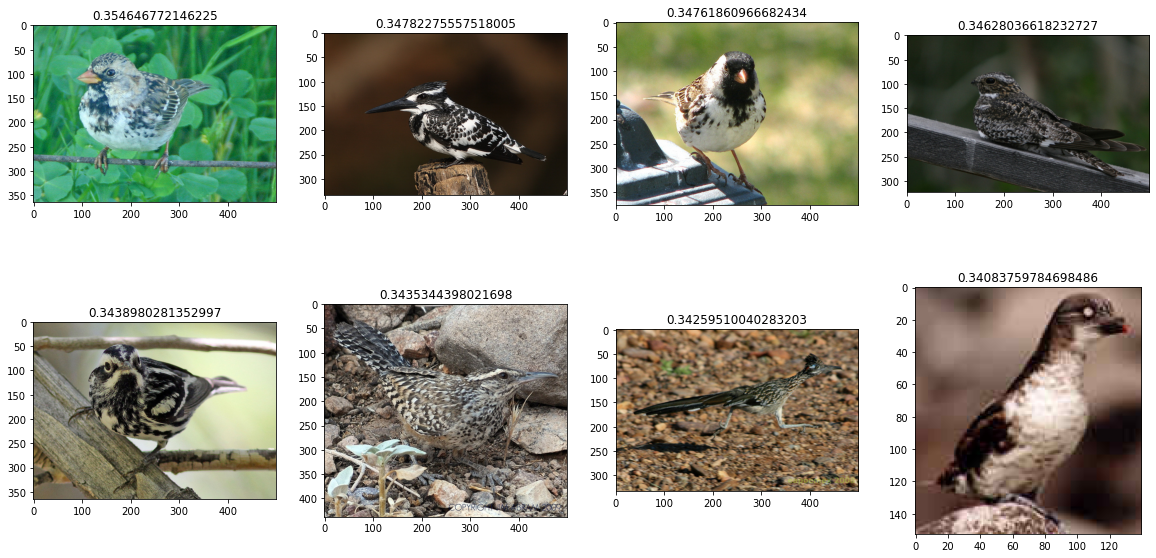

In [80]:
with open('spotted_breast_cosine_similarity.txt', 'r') as f:
    lines = f.readlines()
for i in range(len(lines)):
    lines[i] = lines[i].strip().split()
lines = lines[1:]
#plot 8 images next to each other
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    index = int(lines[i][0])
    if index > 10000:
        img = val_cub[index-30000]['image']
    else:
        img = cub[index]['image']
    img = img.permute(1, 2, 0)
    axs[i//4, i%4].imshow(img)
    axs[i//4, i%4].set_title(lines[i][1])
plt.show()